# Gemma cup detection V2

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

## Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import ipywidgets as widgets
from IPython.display import Image as IpImage
from IPython.display import display
from ipywidgets import HBox

import loaders as lds

%matplotlib inline

## Define Constants

### Paths

In [3]:
data_path = Path("..").joinpath("data_in")
images_path = data_path.joinpath("images")
dataset_path = Path("..").joinpath("data_in", "datasets")

data_path.is_dir(), images_path.is_dir(), dataset_path.is_dir()


(True, True, True)

### Configuration

In [4]:
image_size = 512
batch_size = 1

In [5]:
import torch

def get_device(force=None):
    return force if force is not None else(
    "mps"
    if torch.backends.mps.is_built() is True
    else "cuda"
    if torch.backends.cuda.is_built()
    else "cpu"
)

get_device()

'mps'

## Build Datasets

### Load CSVs

In [6]:
import pandas as pd

train = pd.read_csv(dataset_path.joinpath("train.csv"))
val =pd.read_csv(dataset_path.joinpath("val.csv"))
test = pd.read_csv(dataset_path.joinpath("test.csv"))

train.shape, val.shape, test.shape

((12755, 16), (1586, 16), (1513, 16))

### Build Datasets

In [9]:
train_dataset = lds.GemmaDataset(
    csv=train,
    images_path=images_path,
    transform=lds.get_test_image_transform(image_size=image_size),
)

val_dataset = lds.GemmaDataset(
    csv=val,
    images_path=images_path,
    transform=lds.get_test_image_transform(image_size=image_size),
)

test_dataset = lds.GemmaDataset(
    csv=test,
    images_path=images_path,
    transform=lds.get_test_image_transform(image_size=image_size),
)


### Test Dataset

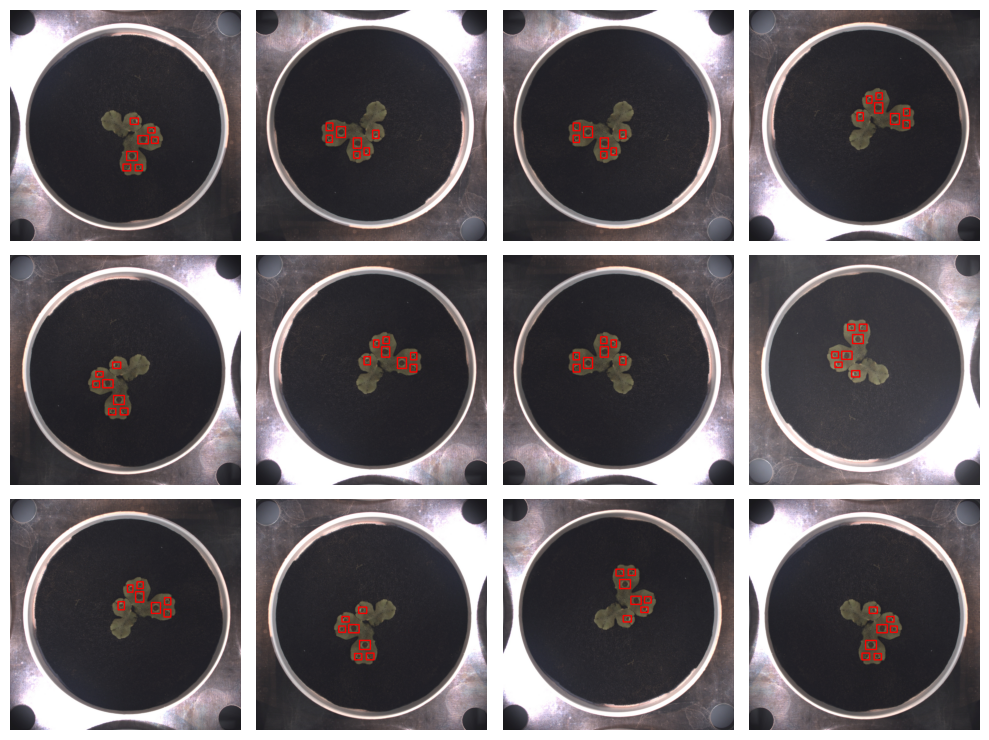

In [10]:
file_name = train.sample(n=1).filename.to_list()[0]

lds.make_patches_grid(
    images=[train_dataset.draw_image_with_boxes(filename=file_name) for _ in range(12)],
    row_count=3,
    col_count=4,
    figsize=(10, 7.5),
)


## Create Data Loaders

In [11]:
from torch.utils.data import DataLoader


def collate_fn(batch):
    return tuple(zip(*batch))


train_data_loader = DataLoader(
    lds.GemmaDataset(
        csv=train,
        images_path=images_path,
        transform=lds.get_train_transform(image_size=image_size),
    ),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)

valid_data_loader = DataLoader(
    lds.GemmaDataset(
        csv=val,
        images_path=images_path,
        transform=lds.get_train_transform(image_size=image_size),
    ),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)

test_data_loader = DataLoader(
    lds.GemmaDataset(
        csv=test,
        images_path=images_path,
        transform=lds.get_train_transform(image_size=image_size),
    ),
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)


In [12]:
train_data_loader.dataset[0]

(tensor([[[-1.6384, -1.6384, -1.6384,  ..., -1.5014, -1.5014, -1.5014],
          [-1.6384, -1.6384, -1.6384,  ..., -1.5357, -1.5014, -1.5014],
          [-1.6384, -1.6384, -1.6384,  ..., -1.5528, -1.5357, -1.5014],
          ...,
          [-1.4500, -1.3987, -1.3987,  ..., -0.7308, -0.6794, -0.6623],
          [-1.4329, -1.4329, -1.4158,  ..., -0.6623, -0.7308, -0.7308],
          [-1.4329, -1.4329, -1.4158,  ..., -0.6623, -0.6281, -0.5253]],
 
         [[-1.5280, -1.5630, -1.5630,  ..., -1.4230, -1.4230, -1.4230],
          [-1.5630, -1.5630, -1.5630,  ..., -1.4580, -1.4230, -1.4230],
          [-1.5630, -1.5805, -1.5805,  ..., -1.4755, -1.4580, -1.4230],
          ...,
          [-1.3880, -1.3354, -1.3354,  ..., -0.6702, -0.6352, -0.6352],
          [-1.3704, -1.3704, -1.3529,  ..., -0.5826, -0.7227, -0.6702],
          [-1.3704, -1.3704, -1.3529,  ..., -0.5301, -0.5126, -0.4076]],
 
         [[-1.2293, -1.2467, -1.2467,  ..., -1.1073, -1.1073, -1.1073],
          [-1.2467, -1.2467,

### Sample

In [13]:
images, targets, _ = next(iter(train_data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]

In [15]:
import numpy as np
boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample = images[0].permute(1,2,0).cpu().numpy()
boxes

array([[255, 189, 270, 201],
       [292, 241, 313, 262],
       [205, 233, 223, 251]], dtype=int32)

## Train

### Build model

In [16]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision

In [17]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

/Users/mavi/Code/python/gemma_cup_detection/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mavi/Code/python/gemma_cup_detection/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
model.roi_heads.box_predictor.cls_score.in_features

1024

In [19]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [20]:
import engine

model.to(get_device(force="cpu"))
optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad], 
    lr=0.005, 
    momentum=0.9, 
    weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None

num_epochs = 200


for epoch in range(num_epochs):
    engine.train_one_epoch(
        model=model,
        optimizer=optimizer,
        data_loader=train_data_loader,
        device=get_device(force="cpu"),
        epoch=epoch,
        print_freq=100,
    )
    lr_scheduler.step()
    engine.evaluate(model, valid_data_loader, device=get_device(force="cpu"))

Epoch: [0]  [   0/3013]  eta: 1:04:33  lr: 0.000010  loss: 1.7434 (1.7434)  loss_classifier: 1.3535 (1.3535)  loss_box_reg: 0.0046 (0.0046)  loss_objectness: 0.3456 (0.3456)  loss_rpn_box_reg: 0.0396 (0.0396)  time: 1.2856  data: 0.0150  max mem: 0


KeyboardInterrupt: 

## Save state dict

In [ ]:
state_output_path = os.path.join("..", "models",datetime.now().strftime("%Y%m%d-%H%M%S") + "state_dict.pth")

In [ ]:
torch.save(
    model.state_dict(), 
    state_output_path
)

## Save model

In [ ]:
model_output_path = os.path.join("..", "models",datetime.now().strftime("%Y%m%d-%H%M%S") + "model.pth")

In [ ]:
torch.save(model, model_output_path)